<a href="https://colab.research.google.com/github/ozlemakboyraz/Brain-Classification-Project/blob/main/MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, models, transforms

# 1. GPU (CUDA) Otomatik Algılama
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Cihaz: {device}")


Cihaz: cuda


In [12]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!cp "/content/drive/MyDrive/brain-dataset/Dataset_224x224.rar" /content/
!unrar x /content/Dataset_224x224.rar /content/

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0713.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0714.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0715.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0716.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0717.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0718.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0719.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0720.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0721.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0722.jpg       26%  OK 
Extracting  /content/Dataset_224x

In [14]:
# 2. Veri Yolları ve Hiperparametreler
DATA_DIR = '/content//Dataset_224x224'
TRAIN_DIR = os.path.join(DATA_DIR, 'Training')
TEST_DIR = os.path.join(DATA_DIR, 'Testing')

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS_PER_FOLD = 10


In [15]:
# 3. MRI Görüntüleri İçin Data Augmentation ve Normalizasyon
# ImageNet istatistikleri transfer learning için standarttır.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [16]:
# 4. MobileNetV2 Model Yapılandırması
def get_mobilenet_model():
    # Pretrained MobileNetV2
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

    # MobileNetV2 18 ana özellik bloğuna sahiptir.
    # İlk 7 bloğu dondurmak yaklaşık %40 katman dondurmaya karşılık gelir.
    features = list(model.features.children())
    freeze_until = 7

    for i, block in enumerate(features):
        if i < freeze_until:
            for param in block.parameters():
                param.requires_grad = False
        else:
            for param in block.parameters():
                param.requires_grad = True

    # Çıkış katmanını (Classifier) 4 sınıf için güncelle
    model.classifier[1] = nn.Linear(model.last_channel, NUM_CLASSES)

    return model.to(device)

In [17]:
# 5. Dataset Sınıfı
class BrainMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = datasets.ImageFolder(root_dir)
        self.transform = transform
        self.classes = self.dataset.classes

    def __getitem__(self, index):
        image, label = self.dataset[index]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.dataset)


In [18]:
# 6. 5-Fold Stratified Cross-Validation
full_train_dataset = BrainMRIDataset(TRAIN_DIR)
labels = [sample[1] for sample in full_train_dataset.dataset.samples]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

final_history = []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    print(f"\n--- FOLD {fold+1} BAŞLIYOR ---")

    train_sub = Subset(full_train_dataset, train_idx)
    val_sub = Subset(full_train_dataset, val_idx)

    # Dinamik Transform Atama
    train_sub.dataset.transform = train_transforms
    val_sub.dataset.transform = val_test_transforms

    train_loader = DataLoader(train_sub, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_sub, batch_size=BATCH_SIZE, shuffle=False)

    model = get_mobilenet_model()

    # Differential Learning Rate Tanımlama
    # MobileNetV2 blok yapısına göre gruplandırma
    optimizer = optim.Adam([
        {'params': model.features[7:11].parameters(), 'lr': 1e-5},  # Orta katmanlar
        {'params': model.features[11:14].parameters(), 'lr': 5e-5}, # Üst orta
        {'params': model.features[14:].parameters(), 'lr': 1e-4},  # Üst katmanlar
        {'params': model.classifier.parameters(), 'lr': 1e-3}      # FC
    ])

    criterion = nn.CrossEntropyLoss()
    fold_h = {
    't_acc': [], 'v_acc': [],
    't_loss': [], 'v_loss': []
}


    for epoch in range(EPOCHS_PER_FOLD):
        model.train()
        t_loss, t_corr = 0.0, 0
        for inputs, labels_b in train_loader:
            inputs, labels_b = inputs.to(device), labels_b.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels_b)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            t_loss += loss.item() * inputs.size(0)
            t_corr += torch.sum(preds == labels_b.data)

        # Validation
        model.eval()
        v_loss, v_corr = 0.0, 0
        with torch.no_grad():
            for inputs, labels_b in val_loader:
                inputs, labels_b = inputs.to(device), labels_b.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels_b)
                _, preds = torch.max(outputs, 1)
                v_loss += loss.item() * inputs.size(0)
                v_corr += torch.sum(preds == labels_b.data)

        fold_h['t_acc'].append((t_corr.double()/len(train_idx)).cpu().item())
        fold_h['v_acc'].append((v_corr.double()/len(val_idx)).cpu().item())
        # Epoch loss hesaplama
        train_epoch_loss = t_loss / len(train_idx)
        val_epoch_loss = v_loss / len(val_idx)

        # History'ye ekleme
        fold_h['t_loss'].append(train_epoch_loss)
        fold_h['v_loss'].append(val_epoch_loss)

        print(
    f"Epoch {epoch+1}: "
    f"Train Loss: {train_epoch_loss:.4f} Acc: {fold_h['t_acc'][-1]:.4f} | "
    f"Val Loss: {val_epoch_loss:.4f} Acc: {fold_h['v_acc'][-1]:.4f}"
)


    final_history.append(fold_h)


--- FOLD 1 BAŞLIYOR ---
Epoch 1: Train Loss: 0.3345 Acc: 0.8757 | Val Loss: 0.1428 Acc: 0.9501
Epoch 2: Train Loss: 0.1172 Acc: 0.9604 | Val Loss: 0.1191 Acc: 0.9580
Epoch 3: Train Loss: 0.0450 Acc: 0.9845 | Val Loss: 0.0925 Acc: 0.9676
Epoch 4: Train Loss: 0.0308 Acc: 0.9902 | Val Loss: 0.0541 Acc: 0.9773
Epoch 5: Train Loss: 0.0218 Acc: 0.9934 | Val Loss: 0.1044 Acc: 0.9703
Epoch 6: Train Loss: 0.0173 Acc: 0.9941 | Val Loss: 0.0734 Acc: 0.9764
Epoch 7: Train Loss: 0.0109 Acc: 0.9958 | Val Loss: 0.1015 Acc: 0.9746
Epoch 8: Train Loss: 0.0260 Acc: 0.9915 | Val Loss: 0.1209 Acc: 0.9685
Epoch 9: Train Loss: 0.0279 Acc: 0.9926 | Val Loss: 0.1104 Acc: 0.9694
Epoch 10: Train Loss: 0.0159 Acc: 0.9941 | Val Loss: 0.0585 Acc: 0.9825

--- FOLD 2 BAŞLIYOR ---
Epoch 1: Train Loss: 0.3180 Acc: 0.8801 | Val Loss: 0.1794 Acc: 0.9318
Epoch 2: Train Loss: 0.0967 Acc: 0.9685 | Val Loss: 0.1146 Acc: 0.9615
Epoch 3: Train Loss: 0.0410 Acc: 0.9860 | Val Loss: 0.0929 Acc: 0.9668
Epoch 4: Train Loss: 0.026

In [19]:
# 7. Test Seti Değerlendirme
print("\n--- TEST SETİ SONUÇLARI ---")
test_dataset = BrainMRIDataset(TEST_DIR, transform=val_test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

all_preds, all_labels, all_probs = [], [], []
model.eval()
with torch.no_grad():
    for inputs, labels_b in test_loader:
        inputs, labels_b = inputs.to(device), labels_b.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_b.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Metrikler
acc = accuracy_score(all_labels, all_preds)
p, r, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

print(f"Accuracy: {acc:.4f} | Precision: {p:.4f} | Recall: {r:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")



--- TEST SETİ SONUÇLARI ---
Accuracy: 0.9703 | Precision: 0.9726 | Recall: 0.9703 | F1: 0.9706 | AUC: 0.9974


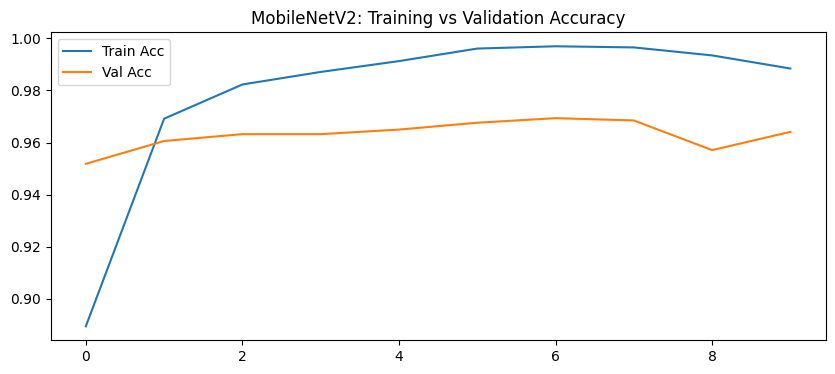

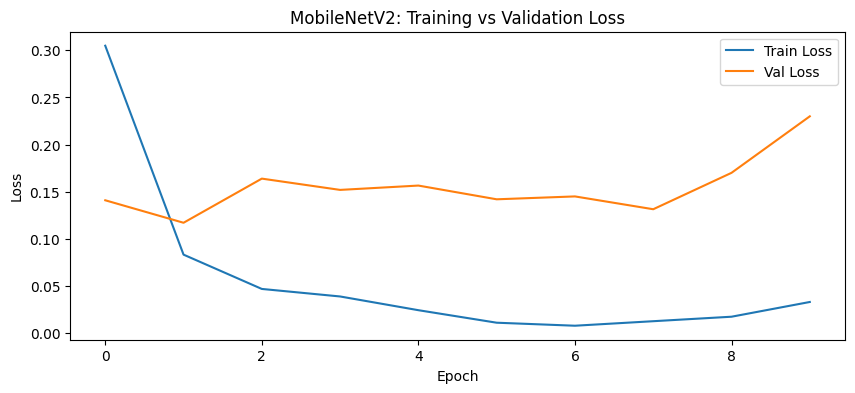

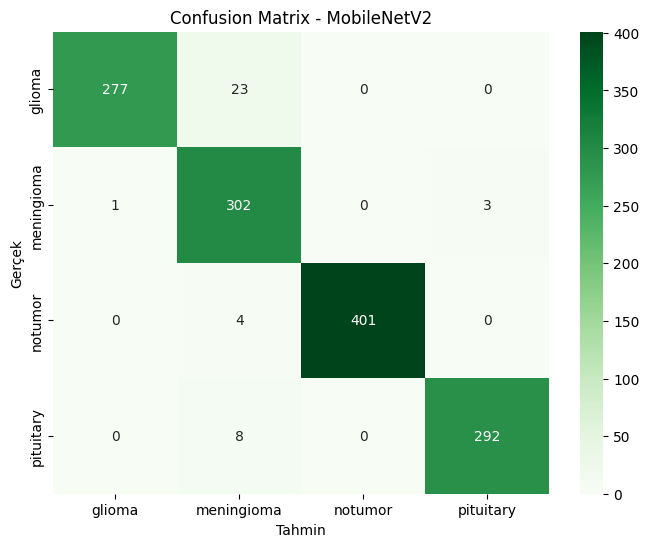

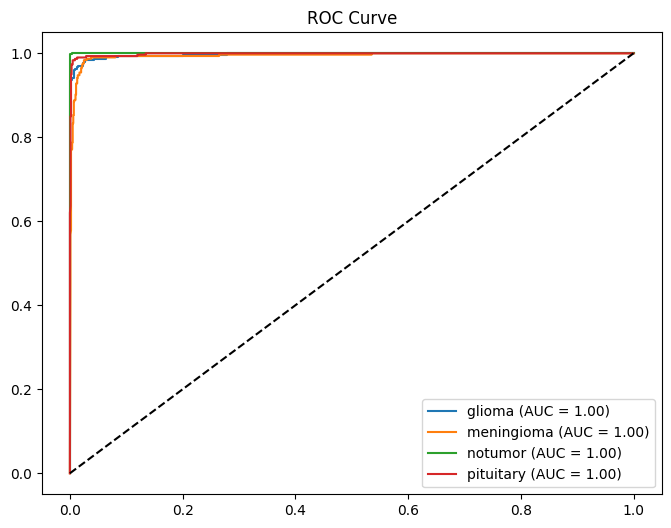

In [20]:
# 8. GRAFİKLER
# Accuracy Grafiği
plt.figure(figsize=(10, 4))
plt.plot(final_history[-1]['t_acc'], label='Train Acc')
plt.plot(final_history[-1]['v_acc'], label='Val Acc')
plt.title('MobileNetV2: Training vs Validation Accuracy')
plt.legend(); plt.show()

# Loss Grafiği
plt.figure(figsize=(10, 4))
plt.plot(final_history[-1]['t_loss'], label='Train Loss')
plt.plot(final_history[-1]['v_loss'], label='Val Loss')
plt.title('MobileNetV2: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Greens',
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title('Confusion Matrix - MobileNetV2')
plt.ylabel('Gerçek'); plt.xlabel('Tahmin'); plt.show()

# ROC Eğrisi
plt.figure(figsize=(8, 6))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(np.array(all_labels) == i, np.array(all_probs)[:, i])
    plt.plot(fpr, tpr, label=f'{test_dataset.classes[i]} (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--'); plt.title('ROC Curve'); plt.legend(); plt.show()